# [Predict the onset of diabetes based on diagnostic measures](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

## Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.](https://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC2245318&blobtype=pdf)

## Variables

- **Pregnancies**: Number of times pregnant

- **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

- **BloodPressur**e: Diastolic blood pressure (mm Hg)

- **SkinThickness**: Triceps skin fold thickness (mm)

- **Insulin**: 2-Hour serum insulin (mu U/ml)

- **BMI**: Body mass index (weight in kg/(height in m)^2)

- **DiabetesPedigreeFunction**: Diabetes pedigree function

- **Age**: Age (years)

- **Outcome**: Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

In [2]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")
for i in range(num_gpus):
    print(f"{i+1}. GPU {i}: {torch.cuda.get_device_name(i)}")

device = 0  # "Select the index of the GPU you wish to use"
torch.cuda.set_device(device)
print(f"GPU selection: {torch.cuda.get_device_name(device)}")

device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device1}")

Number of GPUs available: 1
1. GPU 0: NVIDIA GeForce MX110
GPU selection: NVIDIA GeForce MX110
Using device: cuda:0


## Load data

In [3]:
#data = pd.read_csv("drive/MyDrive/ASIM/diabetes.csv")
data = pd.read_csv("../../data/diabetes.csv")

In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Check any missing values

In [5]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Explore the data relationship

<Axes: xlabel='BloodPressure', ylabel='Count'>

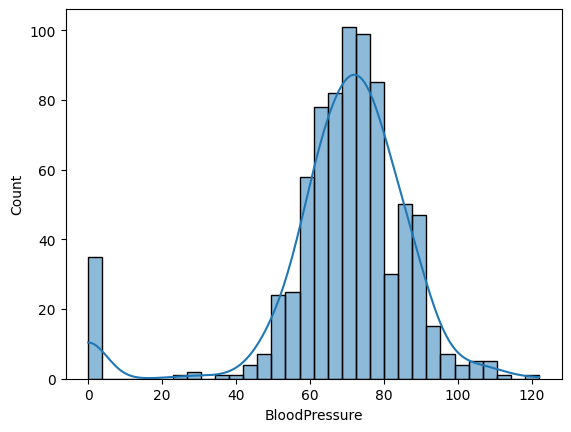

In [6]:
sns.histplot(data=data, x="BloodPressure", kde=True)

<Axes: xlabel='Outcome', ylabel='count'>

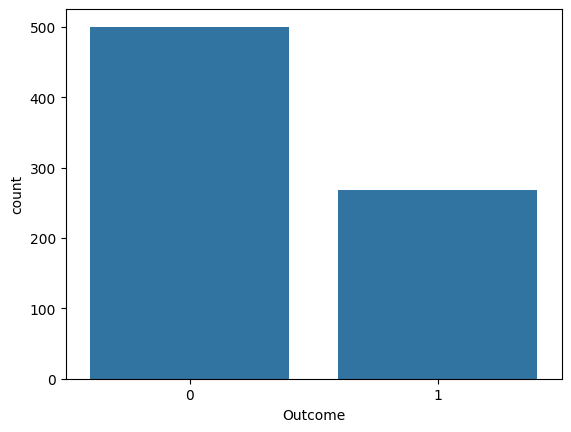

In [7]:
sns.countplot(data=data, x="Outcome")

In [8]:
data.drop(data[data["BloodPressure"]==0].index, inplace=True)

<Axes: xlabel='Outcome', ylabel='count'>

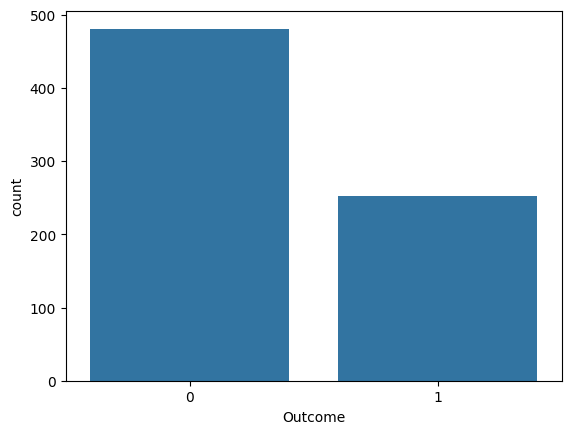

In [9]:
sns.countplot(data=data, x="Outcome")

In [10]:
features = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

output = [
    "Outcome"
]

## Normalize and standarize the data

In [11]:
standardScaler_features = StandardScaler().fit(data[features])
standardScaler_output = StandardScaler().fit(data[output])

standard_features = standardScaler_features.transform(data[features])
standard_output = data[output].values.reshape(-1,1)

In [12]:
class ConjuntoDatosTabulares(Dataset):
  def __init__(self, ent, sal):
    self.inputs = torch.tensor(ent, dtype=torch.float32)
    self.outputs = torch.tensor(sal, dtype=torch.float32)

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.outputs[idx]



In [13]:
bs = 32  # Tamaño del lote

In [14]:
total_data = ConjuntoDatosTabulares(ent=standard_features, sal=standard_output)
total_data_dataloader = DataLoader(total_data, batch_size = 32, shuffle=True)


train_ds, val_ds, test_ds = random_split(total_data, [0.56, 0.14, 0.3])

train_loader = DataLoader(train_ds, batch_size = bs, shuffle=True)
val_loader = DataLoader(val_ds, batch_size = bs, shuffle=True)
test_loader = DataLoader(test_ds, batch_size = bs, shuffle=True)

In [15]:
a = next(iter(total_data_dataloader))
x, y = a

## Create neural network

In [16]:
class RedNeuronal(nn.Module):
  def __init__(self, num_caract, num_salidas):
    super(RedNeuronal, self).__init__()
    self.num_inputs = num_caract
    self.num_outputs = num_salidas
    self.hidden1 = nn.Linear(self.num_inputs, 10)
    self.fact1 = nn.ReLU()
    self.hidden2 = nn.Linear(10, 12)
    self.fact2 = nn.ReLU()
    self.hidden3 = nn.Linear(12, 13)
    self.fact3 = nn.ReLU()
    self.hidden4 = nn.Linear(13, self.num_outputs)
    self.fact4 = nn.Sigmoid()

  def forward(self, x):
    x = self.fact1(self.hidden1(x))
    x = self.fact2(self.hidden2(x))
    x = self.fact3(self.hidden3(x))
    x = self.fact4(self.hidden4(x))
    return x

## Train model

In [17]:
epocas = 1000  # Número de épocas de entrenamiento

In [18]:
red = RedNeuronal(8, 1)
red = red.to(device=device1)

In [19]:
print(red.parameters())

<generator object Module.parameters at 0x7fcf6518c190>


In [20]:
criterio = nn.BCELoss()
optimizador = optim.Adam(red.parameters(), lr=0.001)

In [21]:
# Entrenar la red neuronal
for epoca in range(epocas):
    perdida_entrenamiento = 0
    for X_batch, y_batch in train_loader:
        # Pasar los datos por la red neuronal
        salida = red(X_batch.to(device=device1))

        # Calcular la pérdida
        perdida = criterio(salida, y_batch.to(device=device1))

        # Actualizar los pesos
        optimizador.zero_grad()
        perdida.backward()
        optimizador.step()
        perdida_entrenamiento += perdida.item()

    # Imprimir la pérdida en cada época
    # print(f"Época {epoca+1}, pérdida: {perdida.item():.8f}")
    perdida_validacion = 0
    con_exactitud = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Pasar los datos por la red neuronal
            salida = red(X_batch.to(device=device1))

            # Calcular la pérdida
            perdida = criterio(salida, y_batch.to(device=device1))

            perdida_validacion += perdida.item()

    # Imprimir los resultados
    print(f"Época {epoca+1}")
    print(f"Perdida entrenamiento: {perdida_entrenamiento/len(train_loader)}")
    print(f"Perdida validación: {perdida_validacion/len(val_loader)}")

Época 1
Perdida entrenamiento: 0.7267978053826553
Perdida validación: 0.7159790992736816
Época 2
Perdida entrenamiento: 0.7182281980147729
Perdida validación: 0.7118411660194397
Época 3
Perdida entrenamiento: 0.7104145655265222
Perdida validación: 0.7019551694393158
Época 4
Perdida entrenamiento: 0.7015121854268588
Perdida validación: 0.6946617513895035
Época 5
Perdida entrenamiento: 0.6905638575553894
Perdida validación: 0.6804916262626648
Época 6
Perdida entrenamiento: 0.6800636832530682
Perdida validación: 0.6584434807300568
Época 7
Perdida entrenamiento: 0.6666435966124902
Perdida validación: 0.6408872753381729
Época 8
Perdida entrenamiento: 0.6524532116376437
Perdida validación: 0.6386194676160812
Época 9
Perdida entrenamiento: 0.6351055273642907
Perdida validación: 0.602764829993248
Época 10
Perdida entrenamiento: 0.6161944040885339
Perdida validación: 0.5701538622379303
Época 11
Perdida entrenamiento: 0.5947254254267766
Perdida validación: 0.5622555166482925
Época 12
Perdida ent

Como se puede observar la pérdida de validación empieza a ser mucho mayor que la pérdida de entrenamiento, esto es un claro indicador de Overfitting

## Eval Model